#### Описание решения

1. Воспроизвел предложенное в задаче решение.
2. Провел краткий визуальный анализ данных.
3. Установил исходный бейзлайн, без дополнительных фич и без d2.
4. Добавил несколько своих новых дискретных фич в рамках условия задачи.
5. Затем добавил d2 к полученному датасету и вычислил итоговую RMSE.

    Результат: Baseline RMSE: **48.4719** --> Current RMSE: **45.7082**
    

Комментарии доступны в коде.
    
    
#### Использованные допущения и ограничения
- не проводил оптимизацию гиперпараметров и изменений n_estimators для адекватного сравнения добавок от предложенных фич;
- использовал стандартную функцию mean_squared_error c параметром squared=False, предварительно сверив с предложеннной в решении rmse(a1, a2);

#### Слабые стороны имеющегося решения

1. Фича d2 создана из целевых переменных c3...c5. В данном датасете она работает хорошо, но нет гарантии, что модель не впадает в оверфит на этой фиче, и на произвольных данных результаты могут быть плохими.
2. Не очень понятно введение отдельной функции для вычисления RMSE - в sklearn есть готовая метрика.
3. Использование функции df.loc допустимо только на небольших датасетах, лучше по возможности использовать df.apply

#### Что можно сделать еще

1. Фича с2 имеет очень большой вес и высокую корреляцию с целевыми столбцами. На ее основе можно было бы создать несколько других и, вероятнее всего, улучшить результат. Но на задачу наложены строгие ограничения по количеству и составу новых фич.
2. Есть подозрение, что применение StandardScaler к с1 и с2 существенно улучшит RMSE. Но мы опять упираемся в ограничения исходной задачи.


    


-------------------------------------------------------------------------------------------------------------------------

Младшему исследователю из Вашего отдела дали выполнить задание по дизайну признаков (фич) в новом проекте.
Определите слабые стороны этого решения и попробуйте улучшить результат (RMSE).

Задача была сформулирована так: придумать такие дискретные фичи (не более 5 фичей, каждая фича имеет не более 5 значений), чтобы максимально точно предсказывать по ним значения c3, c4, c5 из имеющегося датасета.

Помимо новых дискретных фич допускается использование c1, c2 и d1 в качестве входных переменных (X).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor

In [2]:
df = pd.read_csv('test_data (1).csv', header=0, index_col=0)
df.head()

,c1,c2,c3,c4,c5,d1
0,1702.339676,97.151127,1187.449039,1090.136386,1106.530204,0.0
1,1667.720643,80.366907,1081.197827,945.367799,1087.782255,1.0
2,1719.730118,69.581754,967.808030,812.721484,995.881811,0.0
3,1681.895917,96.473315,1146.784418,1047.934966,1112.788168,0.0
4,1880.594545,90.238614,1056.165331,909.991794,1021.066083,0.0


### Source reproduction

- just reproduce initial task and RMSE here

In [3]:
def get_discrete_feature1(df):
    if pd.isna(df['c3']) or pd.isna(df['c5']) or pd.isna(df['c4']):
        return None
    c5 = df['c5']
    c3 = df['c3']
    c4 = df['c4']
    if c3 - c5 >= 92 and c3 - c4 < 230:
        return 'cl1'
    if c5 - c3 < 92 and c3 - c5 < 92 and c3 - c4 < 230 and c5 - c4 < 250:
        return 'cl2'
    if c3 - c5 <= 25 and c5 - c3 < 92 and c3 - c4 >= 230:
        return 'cl3'
    if c5 - c3 >= 92 and c5 - c4 < 230:
        return 'cl4'
    else:
        return 'cl5'
    
# add categorial features
for ind in df.index:
    row = df.loc[ind]
    df.loc[ind, 'd2'] = get_discrete_feature1(row)
df = df.dropna() 

x_features = ['c1', 'c2', 'd1', 'd2']
y_features = ['c3', 'c4', 'c5']

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)
model = CatBoostRegressor(silent=True, loss_function='MultiRMSE').fit(train_df[x_features], 
                                                                      train_df[y_features], cat_features=[3])
def rmse(a1, a2):
    diff = (a1 - a2)
    return float(np.mean(np.sqrt(np.mean(diff ** 2, axis=0))))

pred = np.array(model.predict(test_df[x_features]))
print(rmse(pred, test_df[y_features].to_numpy()))

47.61463911502748


#### Comments on initial solution

- sub 'get_discrete_feature1' create a data leak: information about target data moves into X dataset in 'd2' feature. This feature shall not be used. Catboost do it by itself with target meaning. 
- df.loc is better to replace with df.apply
- custom RMSE function can be replaced by sklearn.metrics function 'mean_squared_error(pred, test_df[y_features].to_numpy(), squared=False)'



## Suggested solution

### Data analysis

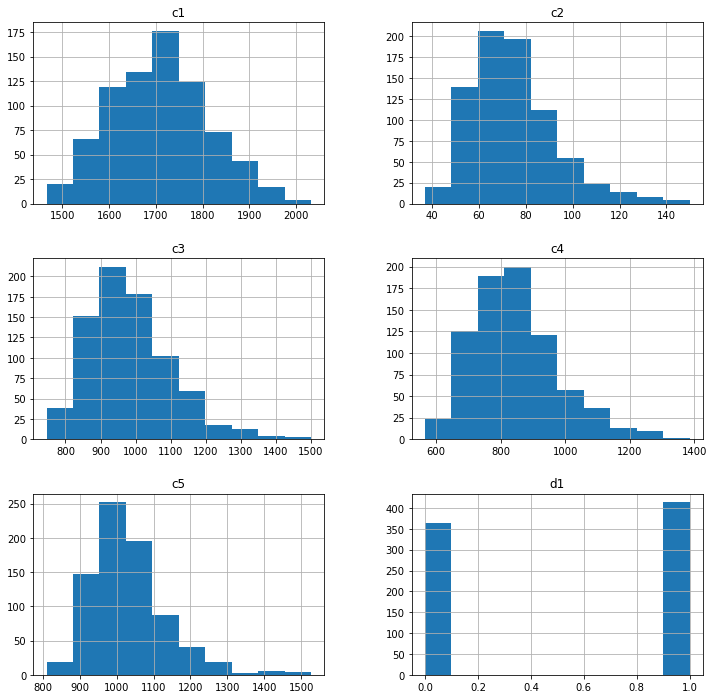

In [4]:
df = pd.read_csv('test_data (1).csv', header=0, index_col=0)

# check data distributions
features=['c1', 'c2', 'c3', 'c4', 'c5', 'd1']
df[features].hist(figsize=(12, 12));

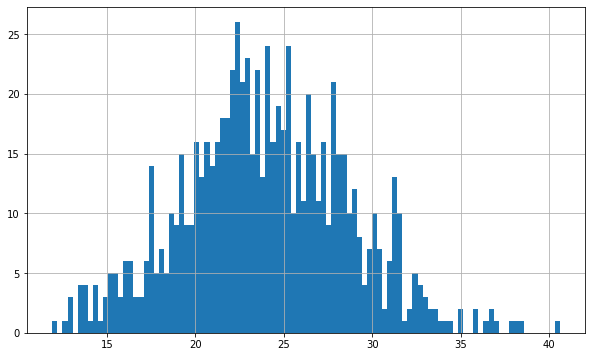

In [5]:
(df.c1/df.c2).hist(bins=100, figsize=(10,6));

In [6]:
# check NaNs
np.sum(df.isna())

c1    0
c2    0
c3    0
c4    1
c5    4
d1    0
dtype: int64

In [7]:
# create list of records with NaNs in c4-c5 features
nan_recs = df[df.c5.isna()==True].index.tolist()
nan_recs.extend(df[df.c4.isna()==True].index.tolist())
nan_recs

[441, 460, 687, 730, 123]

#### Conclusions

- NaNs in target features => records [441, 460, 687, 730, 123] shall be dropped from dataset
- data skewed a bit, possibly will use log or sqrt before splitting to categories

#### Set baseline

In [8]:
df = pd.read_csv('test_data (1).csv', header=0, index_col=0)
df = df.dropna()
print(df.shape)
df.head()

(772, 6)


,c1,c2,c3,c4,c5,d1
0,1702.339676,97.151127,1187.449039,1090.136386,1106.530204,0.0
1,1667.720643,80.366907,1081.197827,945.367799,1087.782255,1.0
2,1719.730118,69.581754,967.808030,812.721484,995.881811,0.0
3,1681.895917,96.473315,1146.784418,1047.934966,1112.788168,0.0
4,1880.594545,90.238614,1056.165331,909.991794,1021.066083,0.0


In [9]:
x_features = ['c1', 'c2', 'd1']
y_features = ['c3', 'c4', 'c5']

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)
model = CatBoostRegressor(silent=True, loss_function='MultiRMSE').fit(train_df[x_features], 
                                                                      train_df[y_features], cat_features=[])
pred = np.array(model.predict(test_df[x_features]))
baseline = np.round(mean_squared_error(pred, test_df[y_features].to_numpy(), squared=False),4)
print("Baseline RMSE: %2.4f" % mean_squared_error(pred, test_df[y_features].to_numpy(), squared=False))

Baseline RMSE: 48.4719


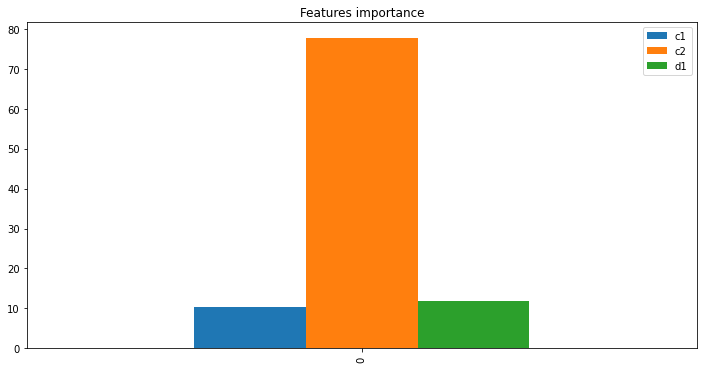

In [10]:
ax = pd.DataFrame([model.feature_importances_],columns=x_features).plot(kind='bar', figsize=(12,6), title="Features importance")

#### Feature engineering

In [11]:
df.d1 = df.d1.apply(lambda x: 'f' if x==0 else 't')

quantile_list = [0., .1, .45, .50, .7, 1]
q_labels = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']

df['q1'] = (df.c1/df.c2).apply(lambda x: 'f' if x<np.mean((df.c1/df.c2)) else 't')+'_'+df.d1
df['q2'] = pd.qcut(df.c1/df.c2, q=quantile_list, labels=q_labels).astype(str)
df['q3'] = pd.qcut(np.log(df.c1*df.c2), q=quantile_list, labels=q_labels).astype(str)
df['q4'] = pd.qcut(round(df.c2,0), q=quantile_list, labels=q_labels).astype(str)

df.head()

,c1,c2,c3,c4,c5,d1,q1,q2,q3,q4
0,1702.339676,97.151127,1187.449039,1090.136386,1106.530204,f,f_f,Q1,Q5,Q5
1,1667.720643,80.366907,1081.197827,945.367799,1087.782255,t,f_t,Q2,Q4,Q4
2,1719.730118,69.581754,967.808030,812.721484,995.881811,f,t_f,Q4,Q2,Q2
3,1681.895917,96.473315,1146.784418,1047.934966,1112.788168,f,f_f,Q1,Q5,Q5
4,1880.594545,90.238614,1056.165331,909.991794,1021.066083,f,f_f,Q2,Q5,Q5


Baseline RMSE: 48.4719
Current RMSE: 47.1782


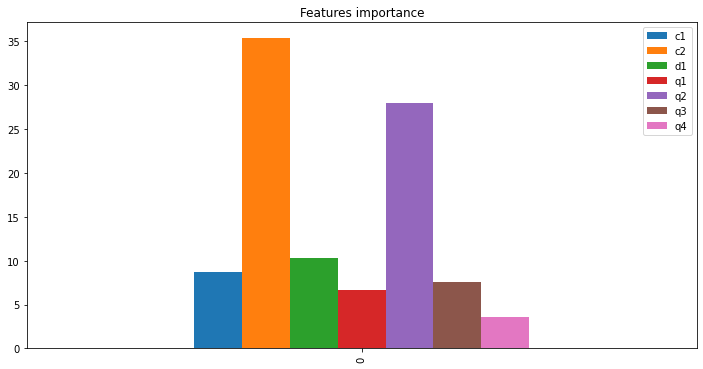

In [12]:
y_features   = ['c3', 'c4', 'c5']
num_features = ['c1', 'c2']
x_features   = []
cat_features = []

for c in df.columns:    
    if c not in y_features: x_features.append(c)
    
for i,c in enumerate(x_features):
    if c not in num_features: cat_features.append(i)

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)
model = CatBoostRegressor(silent=True, loss_function='MultiRMSE').fit(train_df[x_features], 
                                                                      train_df[y_features], cat_features=cat_features)
pred = np.array(model.predict(test_df[x_features]))
print("Baseline RMSE: %2.4f" % baseline)
print("Current RMSE: %2.4f" % mean_squared_error(pred, test_df[y_features].to_numpy(), squared=False))
ax = pd.DataFrame([model.feature_importances_],columns=x_features).plot(kind='bar', figsize=(12,6), title="Features importance")

In [13]:
# now add d2 feature as in initial task

for ind in df.index:
    row = df.loc[ind]
    df.loc[ind, 'd2'] = get_discrete_feature1(row)
df

,c1,c2,c3,c4,c5,d1,q1,q2,q3,q4,d2
0,1702.339676,97.151127,1187.449039,1090.136386,1106.530204,f,f_f,Q1,Q5,Q5,cl2
1,1667.720643,80.366907,1081.197827,945.367799,1087.782255,t,f_t,Q2,Q4,Q4,cl2
2,1719.730118,69.581754,967.808030,812.721484,995.881811,f,t_f,Q4,Q2,Q2,cl2
3,1681.895917,96.473315,1146.784418,1047.934966,1112.788168,f,f_f,Q1,Q5,Q5,cl2
4,1880.594545,90.238614,1056.165331,909.991794,1021.066083,f,f_f,Q2,Q5,Q5,cl2
...,...,...,...,...,...,...,...,...,...,...,...
772,1630.241487,59.990761,847.202994,823.506819,990.289583,t,t_t,Q5,Q2,Q2,cl4
773,1693.725223,88.109343,1076.182680,955.658598,1208.467438,t,f_t,Q2,Q5,Q5,cl5
774,1911.658458,84.421679,1014.765775,915.530432,1044.422575,f,f_f,Q2,Q5,Q5,cl2
775,1951.382558,75.296976,963.907047,873.414881,992.615990,f,t_f,Q4,Q5,Q4,cl2


Baseline RMSE: 48.4719
Current RMSE: 45.7082


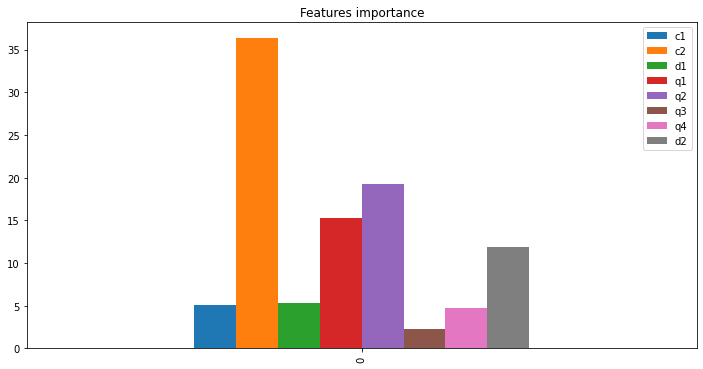

In [14]:
y_features   = ['c3', 'c4', 'c5']
num_features = ['c1', 'c2']
x_features   = []
cat_features = []

for c in df.columns:    
    if c not in y_features: x_features.append(c)
    
for i,c in enumerate(x_features):
    if c not in num_features: cat_features.append(i)

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)
model = CatBoostRegressor(silent=True, loss_function='MultiRMSE').fit(train_df[x_features], 
                                                                      train_df[y_features], cat_features=cat_features)
pred = np.array(model.predict(test_df[x_features]))
print("Baseline RMSE: %2.4f" % baseline)
print("Current RMSE: %2.4f" % mean_squared_error(pred, test_df[y_features].to_numpy(), squared=False))
ax = pd.DataFrame([model.feature_importances_],columns=x_features).plot(kind='bar', figsize=(12,6), title="Features importance")